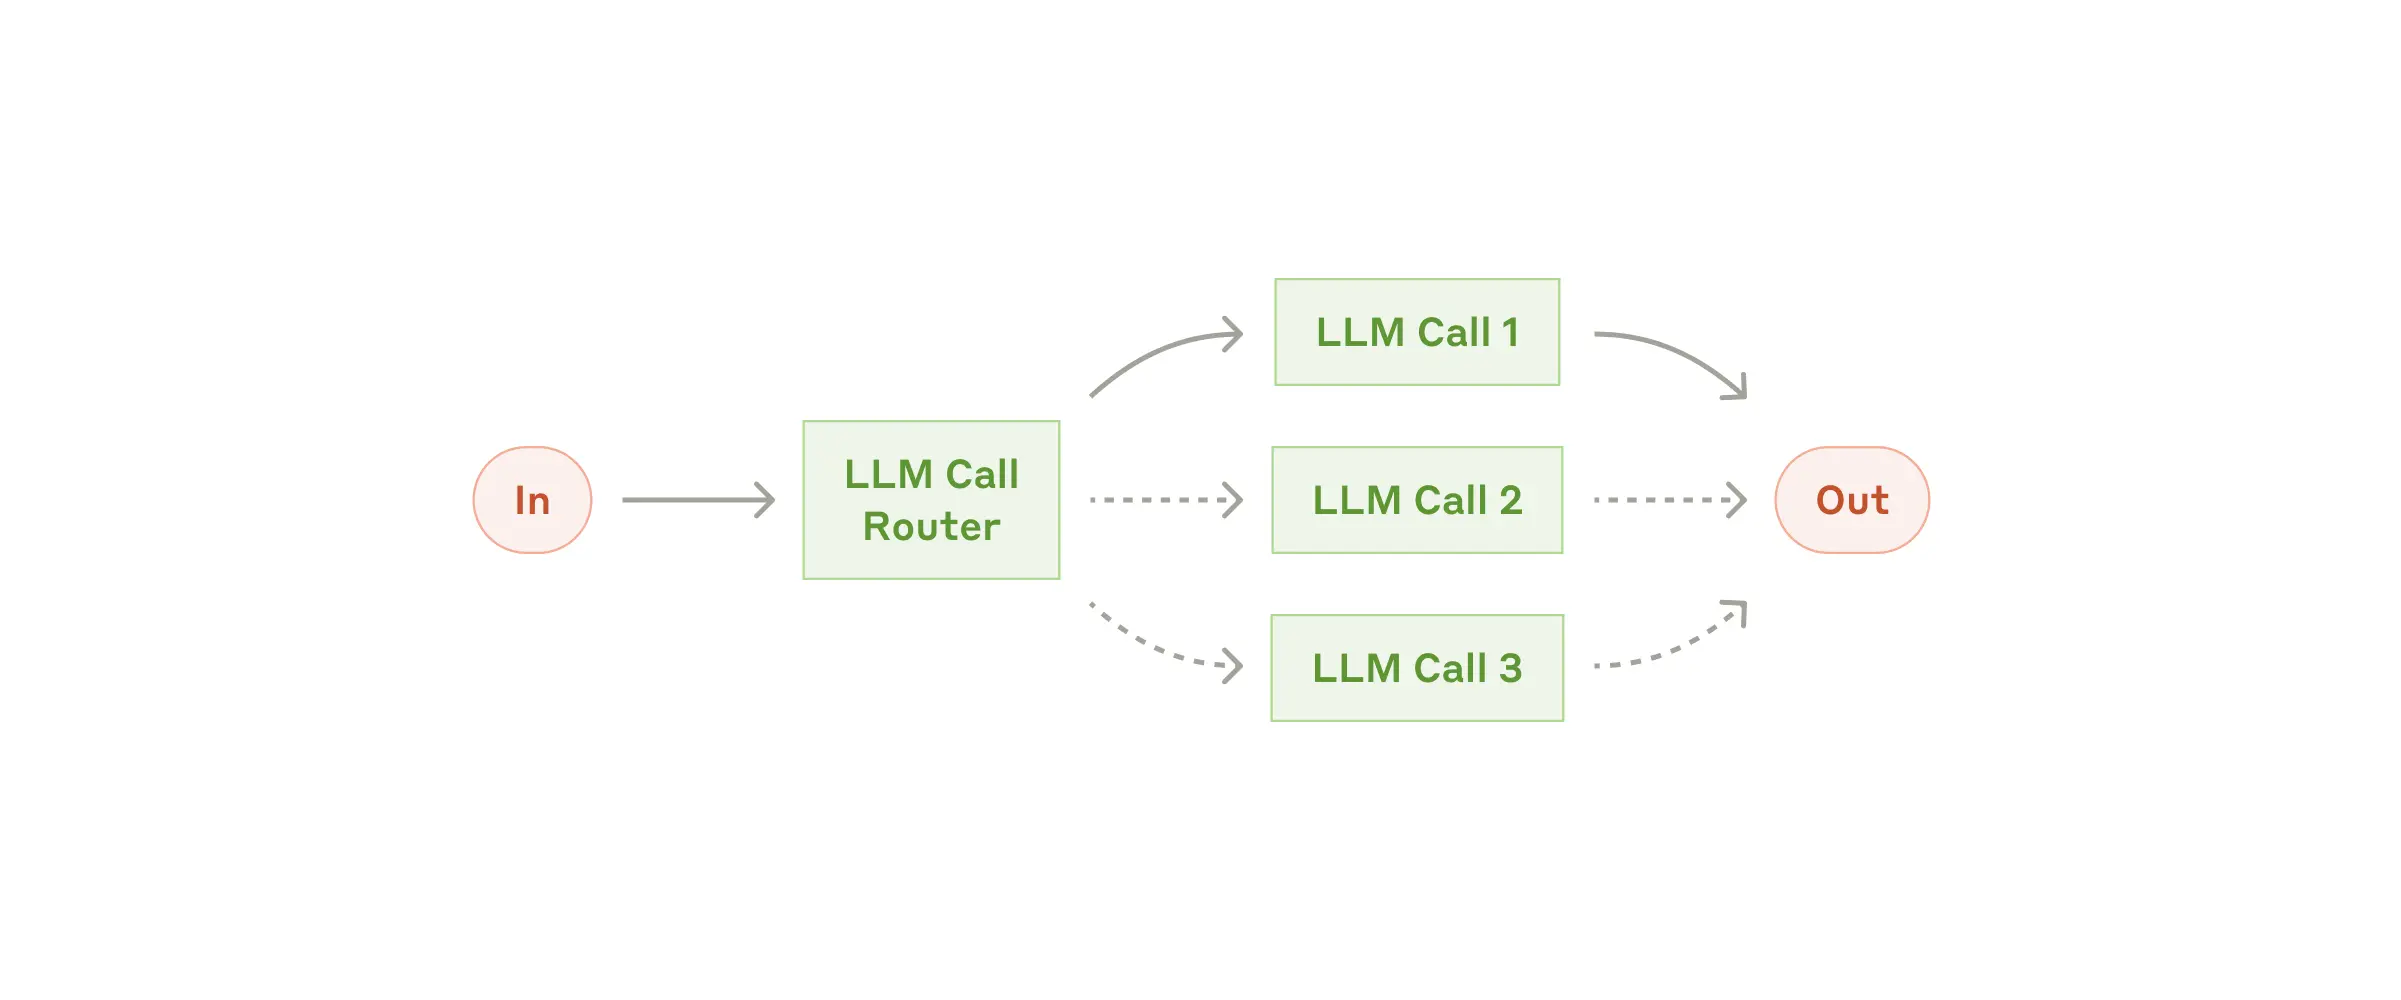

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Enter {var}: ")
    else:
        print(f"{var} already set")
        
_set_env("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY already set


In [10]:
llm.invoke("hi").content

'Hello! How can I assist you today?'

In [2]:
from typing import Literal
from pydantic import BaseModel, Field

class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(None, title="The next step in the routing process")

router = llm.with_structured_output(Route)

In [3]:
from typing import TypedDict

class State(TypedDict):
    input: str
    decision: str
    output: str

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

#Nodes

def generate_joke(state: State):
    msg = llm.invoke(f"Write a short joke about {state['input']}")
    return {"output": msg.content}

def generate_story(state: State):
    msg = llm.invoke(f"Write a 100 word story about {state['input']}")
    return {"output": msg.content}

def generate_poem(state: State):
    msg = llm.invoke(f"Write a short poem about {state['input']}")
    return {"output": msg.content}

def llm_call_router(state: State):
    decision = router.invoke([
        SystemMessage(content="Route the input to story, joke or poem based on user request."),
        HumanMessage(content=state['input'])
    ])
    
    return {"decision": decision.step}

def route_decision(state: State):
    if state['decision'] == "joke":
        return 'generate_joke'
    elif state['decision'] == "story":
        return 'generate_story'
    elif state['decision'] == "poem":
        return 'generate_poem'
    return "fail"

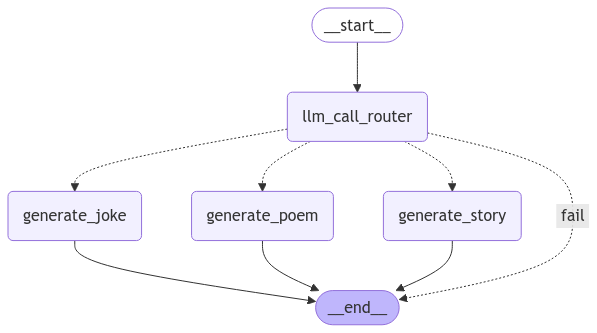

In [5]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(State)

workflow.add_node('generate_joke', generate_joke)
workflow.add_node('generate_story', generate_story)
workflow.add_node('generate_poem', generate_poem)
workflow.add_node('llm_call_router', llm_call_router)


workflow.add_edge(START, 'llm_call_router')
workflow.add_conditional_edges('llm_call_router', route_decision, {
    "generate_joke": 'generate_joke',
    "generate_story": 'generate_story',
    "generate_poem": 'generate_poem',
    "fail": END
})
workflow.add_edge('generate_joke', END)
workflow.add_edge('generate_story', END)
workflow.add_edge('generate_poem', END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
state = chain.invoke({"input": "joke about sumit a software engineer"})

calling router


In [12]:
print(state['output'])

Why did Sumit, the software engineer, bring a ladder to work?

Because he heard the job required raising the code quality!
